# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/datasets/users_behavior.csv")
df.drop_duplicates(inplace=True)
pd.set_option('max_columns', None)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 3214 entries, 0 to 3213

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype  

---  ------    --------------  -----  

 0   calls     3214 non-null   float64

 1   minutes   3214 non-null   float64

 2   messages  3214 non-null   float64

 3   mb_used   3214 non-null   float64

 4   is_ultra  3214 non-null   int64  

dtypes: float64(4), int64(1)

memory usage: 150.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


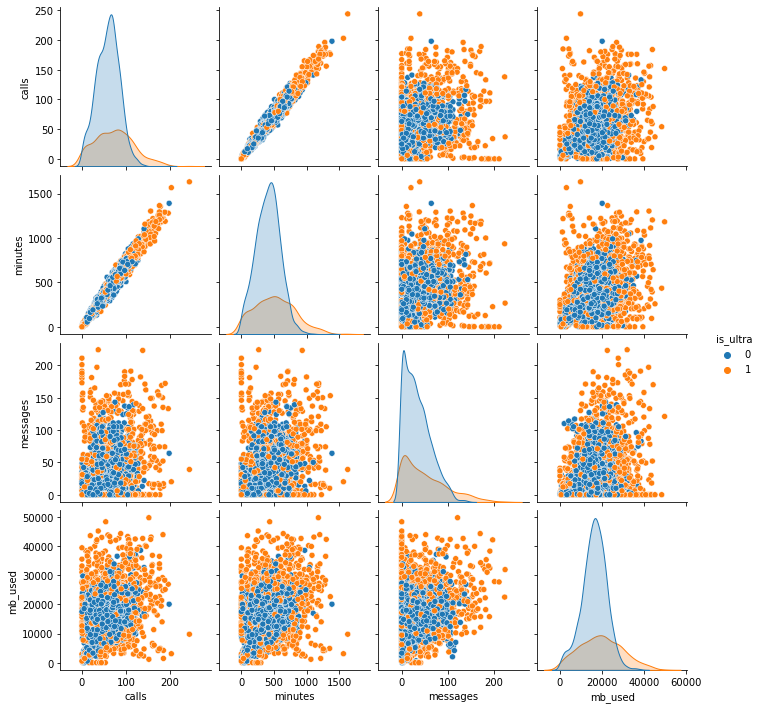

In [4]:
sns.pairplot(data=df, hue="is_ultra")

В данных нет пропусков и преобразование типов значений не нужно.

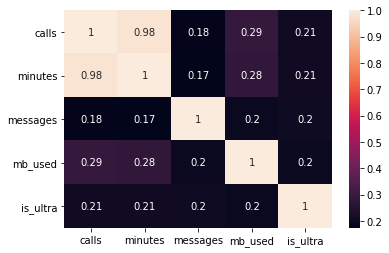

Коэффициент корреляции количества звонков и потраченных минут равен 0.98


In [5]:
sns.heatmap(df.corr(), annot = True)
plt.show()

p_corr = df["calls"].corr(df["minutes"])
print("Коэффициент корреляции количества звонков и потраченных минут равен", p_corr.round(2))

## Разбейте данные на выборки

Деление на выборки в соотношении 60/20/20  
60 - обучающая выборка  
20 - валидационная выборка  
20 - тестовая выборка

In [6]:
features = df.drop(["is_ultra", "calls"], axis=1)
targets = df["is_ultra"]

In [7]:
print(f"Соотношение признаков Ultra/Smart в таргете: {(targets==1.0).sum()}/{(targets==0.0).sum()}")

Соотношение признаков Ultra/Smart в таргете: 985/2229


Выборка несбалансирована, значит модель будет склоняться к предсказанию большего класса

In [8]:
# Создание тестовой и обучающей выборок
features_train_common,features_test, targets_train_common, targets_test = train_test_split(features,
                                                                            targets, 
                                                                            test_size=0.2,                                                                            
                                                                            random_state=27, 
                                                                            stratify=targets)

In [9]:
# Деление выборки на обучающую и валидационную
features_train, features_valid, targets_train, targets_valid = train_test_split(features_train_common,
                                                                            targets_train_common, 
                                                                            test_size=0.25, 
                                                                            random_state=27,
                                                                            stratify=targets_train_common)

Размер выборок

In [10]:
print("Обуающая выборка", features_train.shape, targets_train.shape)
print("Валидационная выборка", features_valid.shape, targets_valid.shape)
print("Тестовая выборка", features_test.shape, targets_test.shape)

Обуающая выборка (1928, 3) (1928,)

Валидационная выборка (643, 3) (643,)

Тестовая выборка (643, 3) (643,)


## Исследуйте модели

**Модель дерева решений**

In [11]:
best_clf_dt = None
best_result_clf = 0
best_max_depth_dt = 0
tr_score = []
val_score = []
depth = []
for i in range(1,21):
    clf = DecisionTreeClassifier(random_state=12345, max_depth=i)
    clf.fit(features_train,targets_train)
    predictions = clf.predict(features_valid)
    result = accuracy_score(targets_valid,predictions)
    tr_score.append(accuracy_score(targets_train,clf.predict(features_train)))
    val_score.append(result)
    depth.append(i)
    if result > best_result_clf:
        best_clf_dt = clf
        best_result_clf = result
        best_max_depth_dt = i
       
print(f"\nЛучшая модель с гиперпараметром max_depth = {best_max_depth_dt}"
        f"\nAccuracy наилучшей модели на валидационной выборке:{best_result_clf.round(5)}")



Лучшая модель с гиперпараметром max_depth = 5

Accuracy наилучшей модели на валидационной выборке:0.78538


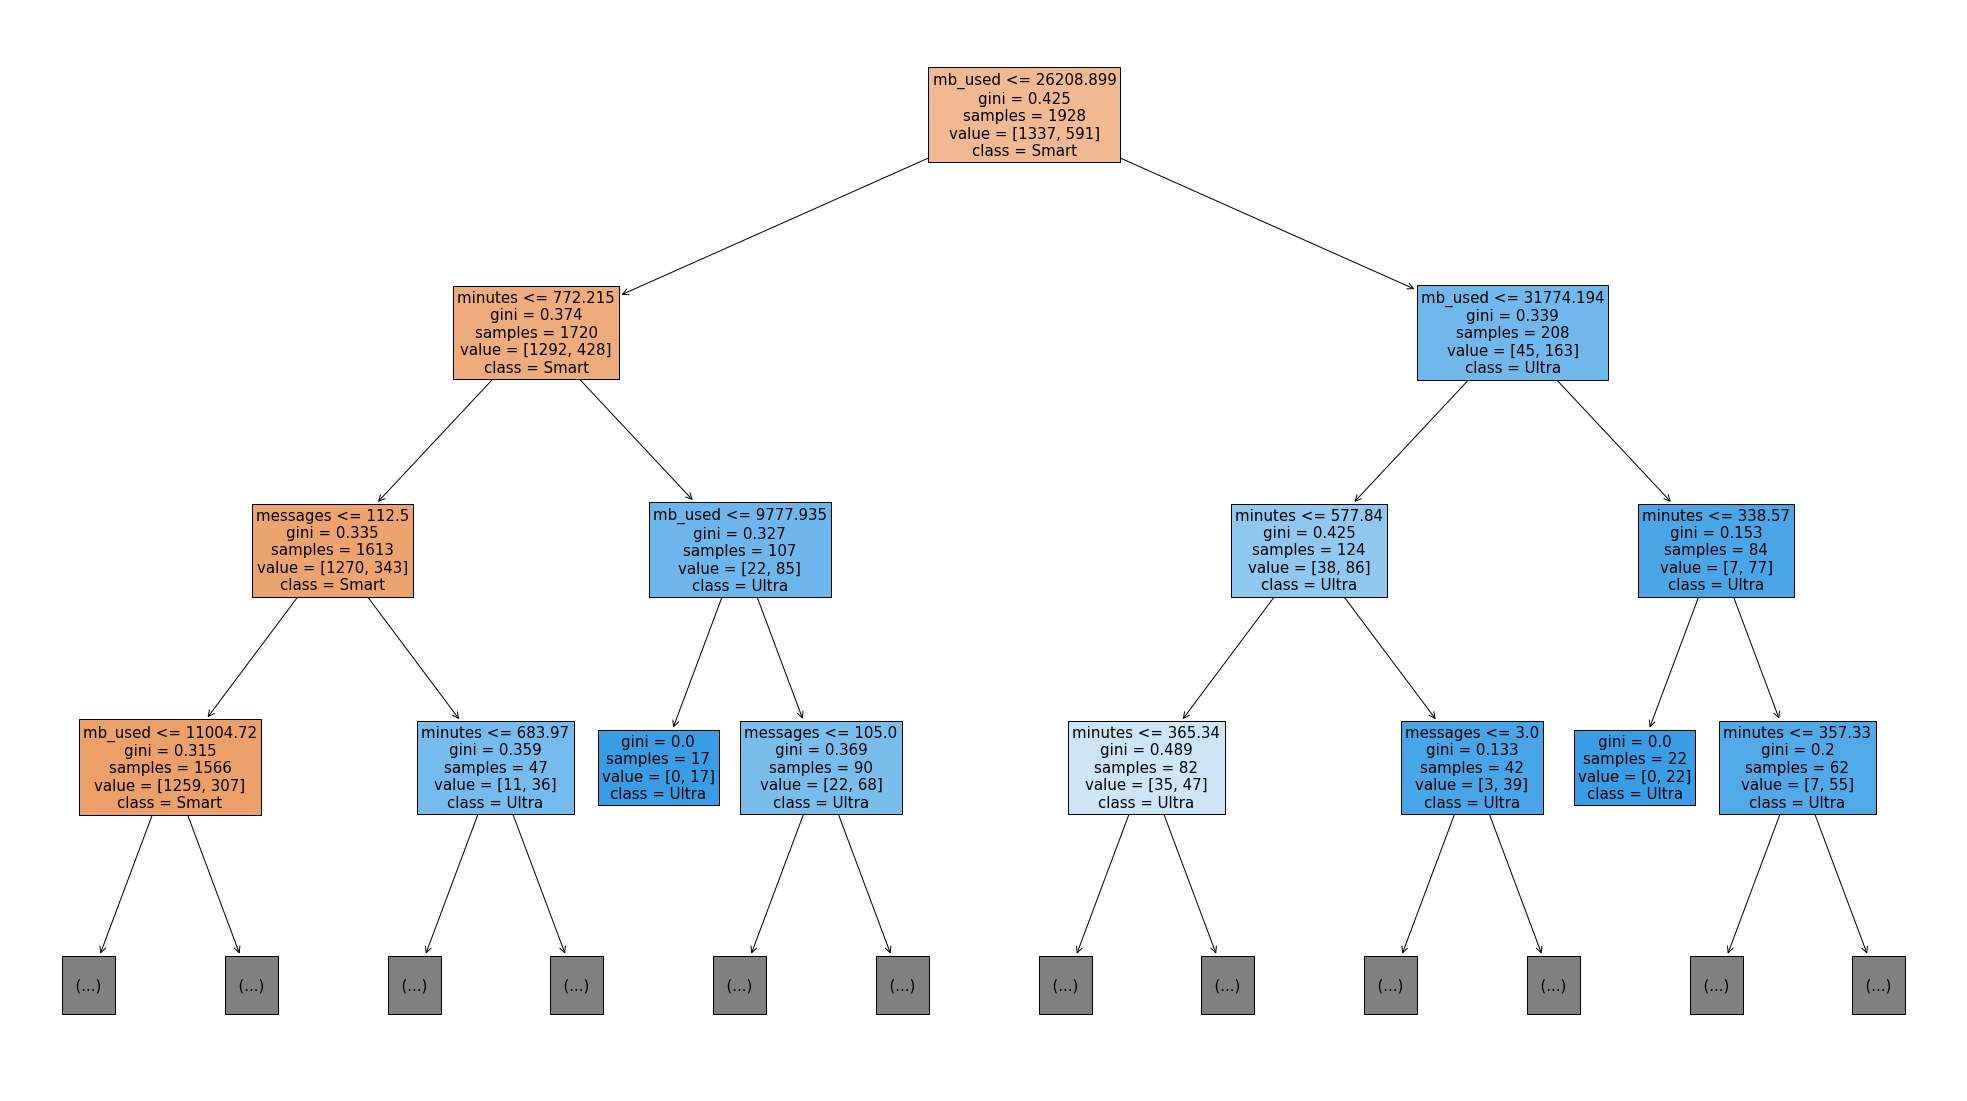

In [12]:
fig = plt.figure(figsize=(35,20))
tree.plot_tree(best_clf_dt, 
               feature_names=features.columns.values,
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               max_depth = 3)
plt.show()

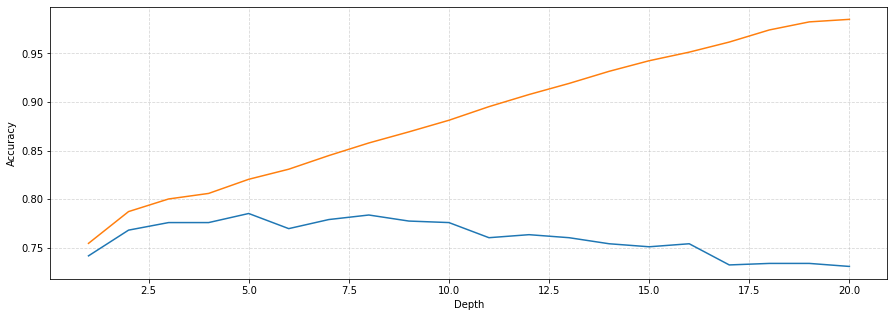

In [13]:
sns.lineplot(y=val_score,x=depth)
sns.lineplot(y=tr_score,x=depth)
plt.grid(linestyle='--', alpha=0.5)
plt.gcf().set_size_inches(15, 5)
plt.xlabel("Depth")
plt.ylabel('Accuracy')
plt.show()

С увеличением глубины accuracy для тестовой выборки возрастает, также наблюдается возрастание значения accuracy для валидной выборки до глубины, равной 5. Однако после 5 точность для валидной выборки снижается, так как модель перестает выявлять зависимости, становится переобученной.

**Модель случайного леса**

In [14]:
best_clf_rf = None
best_result_clf = 0
best_max_depth_rf = 0
for depth in tqdm(range(1,11)):
    for est in range(10, 101, 10):
        clf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        clf.fit(features_train, targets_train)
        predictions = clf.predict(features_valid)
        result = accuracy_score(targets_valid,predictions)
        if result > best_result_clf:
            best_clf_rf = clf
            best_result_clf = result
            best_max_depth_rf = depth
            best_estimators_rf = est
       
print(f"\nЛучшая модель с гиперпараметром max_depth = {best_max_depth_rf}"
      f"\nЛучшая модель с гиперпараметром n_stimators = {best_estimators_rf}"
      f"\nAccuracy наилучшей модели на валидационной выборке:{best_result_clf.round(5)}")

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]



Лучшая модель с гиперпараметром max_depth = 10

Лучшая модель с гиперпараметром n_stimators = 20

Accuracy наилучшей модели на валидационной выборке:0.80249


**Логистическая регрессия**

In [15]:
best_clf_lr = None
best_result_clf = 0
best_max_depth = 0
best_solver = ""
solvers = ["lbfgs", "liblinear", "newton-cg","sag", "saga"]
for i in range(50,501,50):
    for solver in solvers:
        clf = LogisticRegression(random_state=12345, solver=solver, max_iter=1000)
        clf.fit(features_train,targets_train)
        predictions = clf.predict(features_valid)
        result = accuracy_score(targets_valid,predictions)
        if result > best_result_clf:
            best_clf_lr = clf
            best_result_clf = result
            best_max_iter = i
            best_solver = solver
       
print(f"\nЛучшая модель с гиперпараметром max_iter = {best_max_iter}"
      f"\nЛучшая модель с гиперпараметром solver = {best_solver}"
        f"\nAccuracy наилучшей модели на валидационной выборке:{best_result_clf.round(5)}")



Лучшая модель с гиперпараметром max_iter = 50

Лучшая модель с гиперпараметром solver = lbfgs

Accuracy наилучшей модели на валидационной выборке:0.74961


**Вывод:** были рассмотрены 3 модели - дерева решений, случайного леса и логистическая регрессия. необходимой точности достигли две из них - дерево решений и случайного леса.  
Подобраны гиперпараметры для каждой модели:
1. Для дерева решений наилучший результат дает глубина, равная 5. Accuracy 0,79.
2. Для случайного леса наилучший результат дают глубина, равная 9 и количество деревьев 80. Accuracy 0,81.
3. Для логистической регрессии лучшей результат дают максимальное количество итераций 50 и алгоритм lbfgs. Accuracy 0.74.  

Отбросим последнюю модель, так как она не удовлетворяет условиям.

## Проверьте модель на тестовой выборке

**Проверка лучшей модели дерева решений**

In [16]:
dt_model = DecisionTreeClassifier(random_state=12345, max_depth=5)
dt_model.fit(features_train_common, targets_train_common)
predictions_dt = dt_model.predict(features_test)
result_dt = accuracy_score(targets_test,predictions_dt)
print(f"Accuracy модели, обученной на полной выборке {result_dt.round(3)}")


predictions_dt = best_clf_dt.predict(features_test)
result_dt = accuracy_score(targets_test,predictions_dt)
print(f"Accuracy на тестовой выборке {result_dt.round(3)}")

Accuracy модели, обученной на полной выборке 0.81

Accuracy на тестовой выборке 0.818


**Проверка лучшей модели случайного леса**

In [17]:
rf_model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10) 
rf_model.fit(features_train_common, targets_train_common)
predictions_rf = rf_model.predict(features_test)
result_rf = accuracy_score(targets_test,predictions_rf)
print(f"Accuracy модели, обученной на полной выборке {result_dt.round(3)}")

predictions_rf = best_clf_rf.predict(features_test)
result_rf = accuracy_score(targets_test,predictions_rf)
print(f"Accuracy на тестовой выборке {result_rf.round(3)}")

Accuracy модели, обученной на полной выборке 0.818

Accuracy на тестовой выборке 0.824


**Вывод:** accuracy 0.75 достигли только 2 модели из 3 - модель дерева решений и модель случайного леса. Наибольшую точность показала модель случайного леса (0.82).

## Проверьте модели на адекватность

In [18]:
is_0 = (targets_test==0.0).sum()
is_1 = (targets_test==1.0).sum()
print(f"Количество абонентов Ultra (1) {is_1}\n"
        f"Количество абонентов Smart (0) {is_0}")

Количество абонентов Ultra (1) 197

Количество абонентов Smart (0) 446


Вероятность угадать "1" или "0" в выборке составляет 0.5

In [19]:
probability = 0.5
print(f"Случайным образом можно угадать количество абонентов Ultra (1) {(is_1*probability).astype(int)}\n"
        f"Случайным образом можно угадать количество абонентов Smart (0) {(is_0*probability).astype(int)}")

Случайным образом можно угадать количество абонентов Ultra (1) 98

Случайным образом можно угадать количество абонентов Smart (0) 223


**Проверка на адекватность для дерева решений**

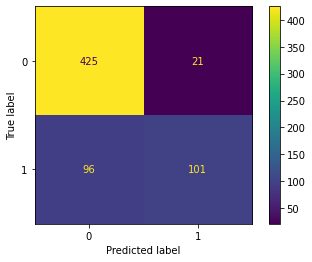

In [20]:
cnf_matrix_dt = confusion_matrix(targets_test,predictions_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_dt,
                              display_labels=best_clf_dt.classes_)
disp.plot()
plt.show()

Модель не справляется с адекватным определением тарифа Ultra. Случайным образом можно определить 97 значений, а можедь определила только 85. При этом модель завышает количество пользователей с тарифом Smart.

**Проверка на адекватность для случайного леса**

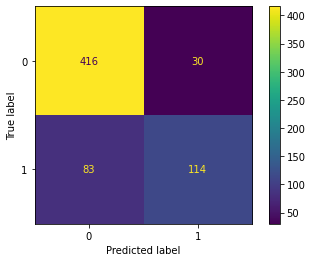

In [21]:
cnf_matrix_rf = confusion_matrix(targets_test,predictions_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_rf,
                              display_labels=best_clf_rf.classes_)
disp.plot()
plt.show()

Вероятность предсказания модели для тарифа Ultra выше случайного, но все равно низкое. Случайным образом можно определить 97 значений, а можедь определила 105. Модель завышает также количество пользователей с тарифом Smart.

Создание наивной модели

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_test, targets_test)
dummy_pred = dummy_clf.predict(features_test)
print(f"Accuracy {accuracy_score(dummy_pred, targets_test).round(3)}")

Accuracy 0.694


## Общий вывод

Обе модели показывают лучшее accuracy, чем модель делающая предсказания на основе наиболее часто встречающегося класса.

В проекте были выполнены исследования по подбору лучшей модели, которая могла бы посоветовать тарифы Smart или Ultra на основе данных о потреченных минутах и мегабайтах, совершенных звонков и количестве сообщений. В работе использовались уже подготовленные данные, чистка и преобразование типов не понадобились.  

Выбока была разделена на три составляющие: обучающая - 60%, валидационная - 20%, тестовая 20%.  

Были рассмотрены три модели и подобраны наилучшие гиперпараметры, которые давали наивысшую точность:
1. Для дерева решений наилучший результат дает глубина, равная 5. Accuracy 0,785.
2. Для случайного леса наилучший результат дают глубина, равная 10 и количество деревьев 20. Accuracy 0,802.
3. Для логистической регрессии лучшей результат дают максимальное количество итераций 50 и алгоритм lbfgs. Accuracy 0.749.
Удовлетворительное значение accuracy (> 0.75) дают два алгоритма - дерево решений и случайный лес.   

На тестовой выборке accuracy модели дерева решений составляет 0.818, а случайного леса 0.8204. Однако дерево решений хуже классифицирует тариф Ultra.

Иходя из всего вышесказанного можно сделать вывод, что если важно быстродействие и меньшие затраты ресурсов, то подойдет дерево решений, если большая точность предсказаний, то случайный лес.